The code in this repository is largely based on the work of Olga Ratushniak and Svitlana Myroshnychenko during their MSc thesis. For more information, please contact Beatriz Cabrero-Daniel.

Some imports:

In [49]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import zCurve as z

Some util functions:

In [50]:
def get_files_in_folder(folder_path):
    try:
        files = [folder_path + "/" + f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        return files
    except Exception as e:
        print(f"An error occurred while getting files in the folder: {str(e)}")
        return []

Analysis of trajectories:

results/example_trajectories//turnleft_synth.csv


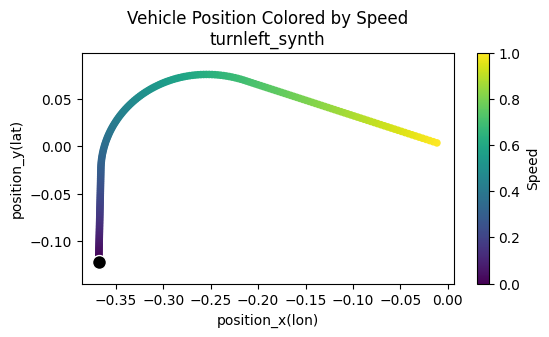

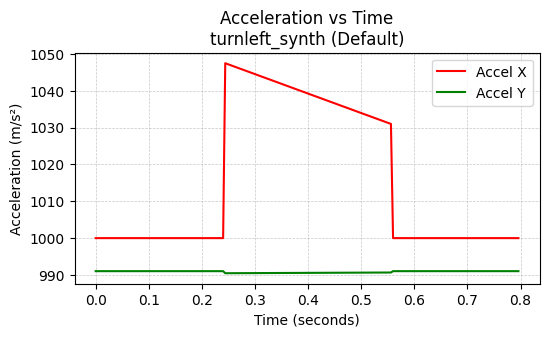

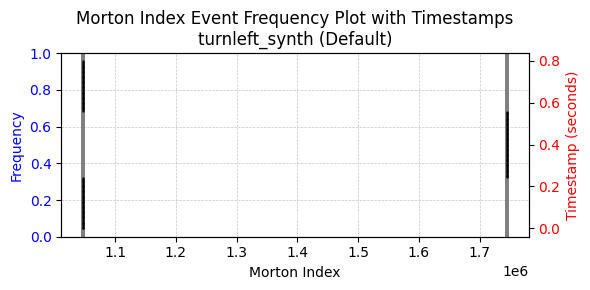

results/example_trajectories//turnleft_real.csv


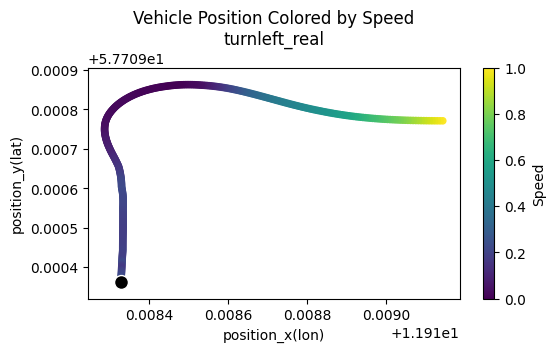

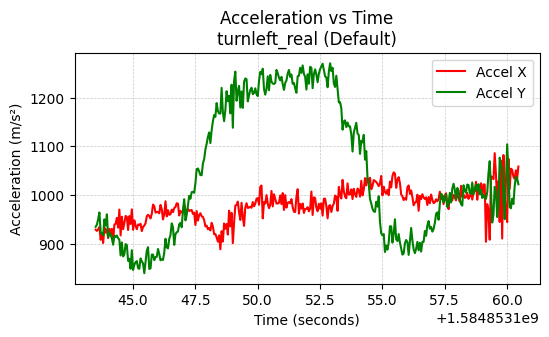

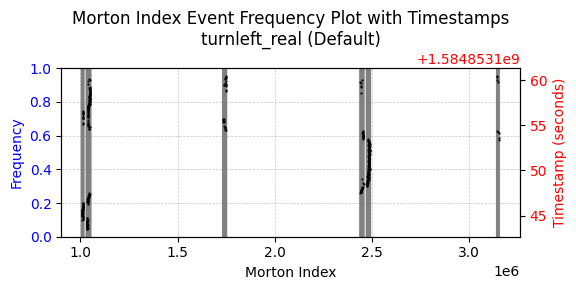

All files processed and plots saved.


In [51]:
# =====================================
# CHECK REAL TRAJECTORIES
# =====================================

common_figsize = (6, 3)  # Common figure size for all plots
output_dir = "results/example_trajectories/plots"  # Folder to save plots
os.makedirs(output_dir, exist_ok=True)

# ===============================
# Data File Processing
# ===============================
data_files = get_files_in_folder("results/example_trajectories/")

# ===============================
# DATA FILE PROCESSING
# ===============================
for file_path in data_files:
    if ".csv" not in file_path:
        continue
    
    if "left" not in file_path:
        continue
    
    print(file_path)

    # Get the file basename without extension
    file_basename = os.path.splitext(os.path.basename(file_path))[0]
    group_name, file_color = ("Default", "gray")
    data = pd.read_csv(file_path, sep=';')
    data['timestamp'] = data['sampleTimeStamp.seconds'] * 1_000_000 + data['sampleTimeStamp.microseconds']

    # ===============================
    # Plot 1: Vehicle Position Colored by Speed
    # ===============================    
    plt.figure(figsize=common_figsize)
    plt.scatter(data['x'], data['y'], c=data['speed'], cmap='viridis', s=20)
    plt.scatter(data.iloc[-1]['x'], data.iloc[-1]['y'], s=100, color="black", edgecolors="white")
    plt.colorbar(label="Speed")
    plt.xlabel("position_x(lon)")
    plt.ylabel("position_y(lat)")
    plt.title(f"Vehicle Position Colored by Speed\n{file_basename}")
    plt.axis('equal')
    plot1_filename = os.path.join(output_dir, f"{file_basename}_position.png")
    plt.savefig(plot1_filename, bbox_inches="tight")
    plt.show()
    plt.close()
    
    # ===============================
    # Plot 2: Raw Acceleration vs Time (No Smoothing)
    # ===============================
    accel_x = (data["accel_x"] + 10) * 100.0
    accel_y = (data["accel_y"] + 10) * 100.0
   
    plt.figure(figsize=common_figsize)
    plt.plot(data['timestamp']/1000000.0, accel_x, label="Accel X", color='red', linewidth=1.5)
    plt.plot(data['timestamp']/1000000.0, accel_y, label="Accel Y", color='green', linewidth=1.5)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Acceleration (m/s²)")
    plt.title(f"Acceleration vs Time\n{file_basename} ({group_name})")
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(loc="upper right")
    plot2_filename = os.path.join(output_dir, f"{file_basename}_signals.png")
    plt.savefig(plot2_filename, bbox_inches="tight")
    plt.show()
    plt.close()

    # -------------------------------
    # Build Morton (Z-order) Index (if chosen or if building both)
    # -------------------------------
    data['Morton_Index'] = [z.interlace(int(x), int(y), bits_per_dim=13) for x, y in zip(accel_x, accel_y)]
    fig, ax1 = plt.subplots(figsize=common_figsize)
    ax1.eventplot(data['Morton_Index'],
                  orientation='horizontal',
                  colors=[file_color],
                  alpha=0.5,
                  lineoffsets=0.5)
    ax1.set_xlabel("Morton Index")
    ax1.set_ylabel('Frequency', color='b')
    ax1.set_ylim((0, 1))
    ax1.tick_params(axis='y', labelcolor='b')

    ax2 = ax1.twinx()
    ax2.scatter(data['Morton_Index'],
                data['timestamp']/1000000.0,
                color='black',
                s=0.5,
                alpha=0.8,
                label="Timestamps")
    ax2.set_ylabel("Timestamp (seconds)", color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    plt.title(f"Morton Index Event Frequency Plot with Timestamps\n{file_basename} ({group_name})")
    ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plot_morton_filename = os.path.join(output_dir, f"{file_basename}_morton.png")
    plt.savefig(plot_morton_filename, bbox_inches="tight")
    plt.show()
    plt.close()

print("All files processed and plots saved.")